In [1]:
import torch
import numpy as np
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from string import punctuation
from torchvision import transforms
import torch.nn as nn

In [2]:
def decode(s):
    r = ''
    for i in [i2w[word.item()] for word in s if word != 0]:
        r += i + ' '
    return r.strip()

In [3]:
def read(path):
    file = open(path, encoding='utf8')
    lines = [line for line in file.readlines()]
    file.close()
    return lines

In [4]:
w2v_path = 'W2V_150.txt'
dataset = read(w2v_path)

num_of_dimensions = int(dataset[1])
dataset = dataset[2:]

vector = [None]*num_of_dimensions
embeddings = {}

for line in dataset:
    s = line.split(' ')
    word = s[0]
    for i in range(num_of_dimensions):
        vector[i] = float(s[i+2])
    embeddings[word] = np.array(vector)

In [5]:
train_negative = 'train_negative_tokenized.txt'
train_neural = 'train_neutral_tokenized.txt'
train_positive = 'train_neutral_tokenized.txt'

test_path = 'test_tokenized_ANS.txt'

In [6]:
negative = read(train_negative)
neural = read(train_neural)
positive = read(train_negative)

test_file = read(test_path)

In [7]:
test_set = []
test_labels_ = []

for i in range(0,len(test_file),2):
    test_set.append(test_file[i])
    test_labels_.append(test_file[i+1].strip('\n'))    

In [8]:
train_set = negative + neural + positive

# bỏ những dòng trống
train_set = [i for i in train_set if i != '\n']
train_size = len(train_set)
test_size = len(test_set)

# đưa tất cả về chữ thường 
for i in range(train_size):
    train_set[i] = train_set[i].lower()
for i in range(test_size):
    test_set[i] = test_set[i].lower()

# bỏ dấu kết thúc câu
for i in range(train_size):
    for p in punctuation:
        train_set[i] = train_set[i].replace(p, ' ')
for i in range(test_size):
    for p in punctuation:
        test_set[i] = test_set[i].replace(p, ' ')
        
# bỏ các ký tự unicode
for i in range(train_size):
    train_set[i] = train_set[i].replace('\ufeff', '').replace('\xa0', '').replace('\u200e', '').replace('\u200b', '')
for i in range(test_size):
    test_set[i] = test_set[i].replace('\ufeff', '').replace('\xa0', '').replace('\u200e', '').replace('\u200b', '')

# bỏ các chuỗi mặt cười
for i in range(train_size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])

# bỏ các chuỗi '...'
for i in range(train_size):
    train_set[i] = re.sub(r'\.+', '', train_set[i])

In [9]:
vocab = Counter()

for i, sentence in enumerate(train_set):
    train_set[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        vocab.update([word]) # cập nhật số lần xuất hiện của word
        train_set[i].append(word)

for i, sentence in enumerate(test_set):
    test_set[i] = []
    for word in nltk.word_tokenize(sentence):
        test_set[i].append(word)

In [10]:
vocab_ = sorted(vocab, key=vocab.get, reverse=True) # sắp xếp theo thứ tự tần suất xuất hiện giảm dần

In [11]:
w2i = {w:i+1 for i,w in enumerate(vocab)} # w2i[word] ->  mức độ xuất hiện word trong corpus
# (1 là xuất hiện nhiều nhất, số 0 để padding)
i2w = {i+1:w for i,w in enumerate(vocab)}

In [12]:
train_set_vct = np.empty_like(train_set)
for i, sentence in enumerate(train_set):
    train_set_vct[i] = [w2i[word] if word in w2i else 0 for word in sentence] # thay từ bằng w2i của từ, nếu không trong corpus -> 0

test_set_vct = np.empty_like(test_set)
for i, sentence in enumerate(test_set):
    test_set_vct[i] = [w2i[word] if word in w2i else 0 for word in sentence]

In [13]:
count = np.zeros(len(train_set_vct))
for s in train_set_vct:
    count[len(s)] += 1

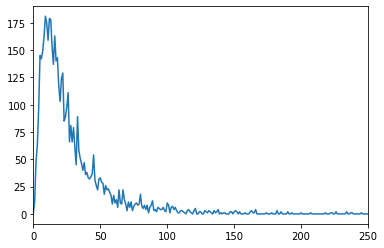

In [14]:
plt.plot(count)
plt.xlim((0,250))
plt.show() # phân bố độ dài các câu

In [15]:
normalized_len = 150 # đa số câu đều < 150, chuẩn hóa độ dài câu về 150

In [16]:
def normalize_length(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)
    
    for i, review in enumerate(sentences):
        review_len = len(review)
        
        if review_len <= seq_length: # ngắn hơn seq_length -> chèn thêm 0 vào đầu
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length: # dài hơn -> chỉ lấy <seq_length> số đầu tiên
            new = review[0:seq_length]
        
        features[i] = np.array(new)
    return features

In [17]:
train_set_vct_normalized = normalize_length(train_set_vct, normalized_len)
test_set_vct_normalized = normalize_length(test_set_vct, normalized_len)

In [18]:
train_labels = np.ones(len(train_set_vct_normalized), dtype=int)
train_labels[:1700] = -1 # negative
train_labels[1700:3400] = 0 # neural

test_labels = np.zeros(len(test_labels_), dtype=int)
for i in range(len(test_labels)):
    l = test_labels_[i]
    if l == 'POS':
        test_labels[i] = 1
    elif l == 'NEG':
        test_labels[i] = -1
        
# test_labels_[test_labels_ == 'POS'] = 1
# test_labels_[test_labels_ == 'NEU'] = 0
# test_labels_[test_labels_ == 'NEG'] = -1

In [19]:
bs = 50

In [20]:
class TokenizedWords(torch.utils.data.Dataset):
    def __init__(self, train_set_vct_normalized, labels):
        self.train_set_vct_normalized = train_set_vct_normalized
        self.labels = labels
    
    def __len__(self):
        return len(self.train_set_vct_normalized)

    def __getitem__(self, idx):
        item = torch.from_numpy(self.train_set_vct_normalized[idx])
        label = torch.tensor(self.labels[idx])

        return (item, label)

In [21]:
train_data = TensorDataset(torch.from_numpy(train_set_vct_normalized), torch.from_numpy(train_labels))
train_loader = DataLoader(train_data, shuffle=True, batch_size=bs)

In [22]:
test_data = TokenizedWords(test_set_vct_normalized, test_labels)
test_loader = DataLoader(test_data, shuffle=True, batch_size=bs)

In [23]:
itr = iter(train_loader)
sentences, ground_truth = next(itr)
for s in sentences[:5]:
    print(decode(s))
print(ground_truth[:5])

lại không có gì khác biệt
phải cài miband notification hoặc trong mifit phải chọn chế độ là hiện tất cả app rồi chọn 3 app dùng để cài rung khi có tin nhắn trong đó phải chọn cái app mesage
như cầm cái tv theo
suface giá cao quá so với giá trị sử dụng
tin ông bb mấy năm mà nản lần đầu con playbook hứa lên bb 10 lần 2 con z 30 thì ông chạy sang android nếu 2 sản phẩm kia là thật thì blackberry nên giải tán phần cứng và chuyển sang kinh doanh phần mềm và dịch vụ là vừa thật sự mấy hãng tq nó làm máy còn đẹp hơn
tensor([ 1,  0,  1, -1, -1])


In [24]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [25]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 150
output_size = 3
hidden_dim = 256
model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, no_layers)
# print(model)

In [26]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
for epoch in range(2):
    h = model.init_hidden(bs)
    running_loss = 0.0
    for _, data in enumerate(train_loader, 0):
        h = tuple([e.data for e in h])
        inputs, labels = data
        optimizer.zero_grad()
        outputs, h = model(inputs, h)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

print('Finished')

Finished


In [28]:
test = iter(test_loader)
reviews, ground_truths = test.next()
for s in reviews[:5]:
    print(decode(s))
print(ground_truths[:5])

rất đẹp mong cho mọi người cứ chê đi để sang năm xách e nó dùng hi
đỡ lag hơn 9 3 1 nhiều mà
thế thì cho dù con của em có ko yếu pin thì em cũng khuyên bác ko nên chọn nó thật đấy pin yếu là điểm hạn chế cỗ hữu của dòng này rồi
bài test thể hiện rx 460 yếu sinh lí hơn gtx 950 mà chắc bạn không đọc bạn nên nhớ 950 là thế hệ cũ nếu nvidia ra thế vga thế hệ pascal mới thay thế 950 thì con 460 sống sao nổi vulkan cũng tương thích tốt với các vga nvidia mà nếu nhu cầu mua chỉ để chơi game thì nvidia nó làm ông trùm thế giới ngầm đứng sau các nhà phát triển game rồi lo vga không support với các game mới bằng thừa
thiết kế đẹp cấu hình mạnh nhưng ko bán dc ở việt nam
tensor([ 1,  1, -1,  0,  1])


In [29]:
test_losses = []
num_correct = 0
h = model.init_hidden(bs)

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])

    output, h = model(inputs, h)

    pred = torch.round(output.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test accuracy: 33.333%


In [30]:
seq_length = 150
s = nltk.word_tokenize('tệ quá đi')
s = [embeddings[word] if word in embeddings else 0 for word in s]

if len(s) <= seq_length:
    zeroes = list(np.zeros(seq_length-len(s)))
    s = zeroes+s
elif len(s) > seq_length:
    s = s[0:seq_length]

s = np.array(s)
s = np.expand_dims(s, axis=0)
s = np.expand_dims(s, axis=0)


bs = 1
h = model.init_hidden(bs)
h = tuple([each.data for each in h])
output, h = model(s, h)
pred = torch.round(output.squeeze())

TypeError: 'int' object is not callable